<a href="https://colab.research.google.com/github/shakib68/NYC-taxi-capstone/blob/main/Copy_of_NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

**Independent Variables**

id — a unique identifier for each trip

vendor_id — a code indicating the provider associated with the trip record

pickup_datetime — date and time when the meter was engaged

dropoff_datetime — date and time when the meter was disengaged

passenger_count — the number of passengers in the vehicle (driver entered value)

pickup_longitude — the longitude where the meter was engaged

pickup_latitude — the latitude where the meter was engaged

dropoff_longitude — the longitude where the meter was disengaged

dropoff_latitude — the latitude where the meter was disengaged distance:distance covered speed ; speed calculated

store_and_fwd_flag — This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server — Y=store and forward; N=not a store and forward trip.

**trip_duration** = dependent variable

**Importing  libraries**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

import statsmodels.formula.api as sm
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings; warnings.simplefilter('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Loading data**

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/AlmaBetter/capstone project 2/Copy of NYC Taxi Data.csv")


In [ ]:
df.head()

In [ ]:
df.tail()

**Checking Datatype in our Dataset**

In [ ]:
df.dtypes

In [ ]:
df.describe()

In [ ]:
df.shape

**Checking missing value**

In [ ]:
# Missing Value Count Function
def show_missing():
    missing = df.columns[df.isnull().any()].tolist()
    return missing

# Missing data counts and percentage
print('Missing Data Count')
print(df[show_missing()].isnull().sum().sort_values(ascending = False))
print('--'*50)
print('Missing Data Percentage')
print(round(df[show_missing()].isnull().sum().sort_values(ascending = False)/len(df)*100,2))

**Here you can see there is no missing value in our dataset, So will proceed for solution and analysis**

**Importing geopy library to calculate distance**


In [ ]:
from geopy.distance import great_circle

**Calculte distance betwee pickup and dropoff points**

In [ ]:
#Calculte distance betwee pickup and dropoff points
def distance_cal(pickup_lat,pickup_long,dropoff_lat,dropoff_long):
 
 start_coordinates=(pickup_lat,pickup_long)
 stop_coordinates=(dropoff_lat,dropoff_long)
 
 return great_circle(start_coordinates,stop_coordinates).km

In [ ]:
# Calculating distance for each trip
df['distance'] = df.apply(lambda df: distance_cal(df['pickup_latitude'],df['pickup_longitude'],df['dropoff_latitude'],df['dropoff_longitude'] ), axis=1)


In [ ]:
df['distance']

**converting it to datetime**

In [ ]:
#convert it to datetime
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime']=pd.to_datetime(df['dropoff_datetime'])

In [ ]:

df['pickup_day_no']=df['pickup_datetime'].dt.weekday
df['dropoff_day_no']=df['dropoff_datetime'].dt.weekday
df['pickup_hour']=df['pickup_datetime'].dt.hour
df['dropoff_hour']=df['dropoff_datetime'].dt.hour
df['pickup_month']=df['pickup_datetime'].dt.month
df['dropoff_month']=df['dropoff_datetime'].dt.month

In [ ]:
df.shape

**Checking for outlier in column trip duration**

In [ ]:
# the skewed box plot shows us the presence of outliers 
sns.boxplot(y=df['trip_duration'])
plt.show()
columns=['trip_duration']
n = 1
plt.figure(figsize=(20,15))

for column in columns:
  plt.subplot(4,4,n)
  n = n+1
  sns.boxplot(df[column])
  plt.tight_layout()

**You can see that there are some outliers in dataset so we will try to fin 0-100 percentile value  to find a the correct percentile value for removal of outliers**

In [ ]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =df["trip_duration"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])


**We can see that the value of outlier is in the range from 90 to 100 percentile but we do not  know exactly so we do some more step from 90-100**

In [ ]:
#calculating 90-100th percentile to find a the correct percentile value for removal of outliers
for i in range(90,100):
    var =df["trip_duration"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

In [ ]:
#calculating 99-100th percentile to find a the correct percentile value for removal of outliers
for i in np.linspace(99.0,100.0,10 ,endpoint=False):
    var =df["trip_duration"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])


**From here we can set the value for trip duration less than 18000 ,otherwise all the values>18000 will be treated as outlier becouse more than 5 hour of taxi trip is not feasible**

In [ ]:
df.trip_duration.groupby(pd.cut(df.trip_duration, np.arange(1,max(df.trip_duration),3600))).count()

In [ ]:
df = df[df.trip_duration <= 18000]

**Oulier in distance column**

In [ ]:

sns.boxplot(y=df['distance'])
plt.show()

**we can see that there are some outlier**

In [ ]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =df["distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

**Will try to find 90-100 percentile value to get clear value**

In [ ]:
#calculating 90-100th percentile to find a the correct percentile value for removal of outliers
for i in range(90,100):
    var =df["distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

**have to see the percentile from 99-100 to get more clear picture**

In [ ]:
#calculating 99-100th percentile to find a the correct percentile value for removal of outliers
for i in np.linspace(99.0,100.0,10 ,endpoint=False):
    var =df["distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

In [ ]:
df['distance'].value_counts()


**We can take value as 30 becouse 99.9 percentile value are less than it**

In [ ]:
df=df[df['distance']<30]

**We will only keep those observation whose distance is greater than 0 ,as equal to zero will be a false entry**

In [ ]:
df=df[df['distance']!=0]


In [ ]:
df['distance'].value_counts()


**Passenger column outlier treatment**

In [ ]:
df.passenger_count.value_counts()


In [ ]:
plt.figure(figsize = (20,5))
sns.boxplot(df.passenger_count)
plt.show()

**we can see that there are some outlier**

There are some trips with 0 passenger count.

Few trips consisted of even 7, 8 or 9 passengers. Clear outliers and pointers to data inconsistency

Most of trip consist of passenger either 1 or 2

So we would replace the 0 passenger count with 1.

In [ ]:
df['passenger_count'] = df.passenger_count.map(lambda x: 1 if x == 0 else x)


**Also, we will remove the records with passenger count > 7, 8 or 9 as they are extreme values and looks very odd to be ocupied in a taxi.**

In [ ]:
df = df[df.passenger_count <= 6]

In [ ]:
sns.countplot(x='passenger_count',data=df)





**Outlier in speed column**

#EDA

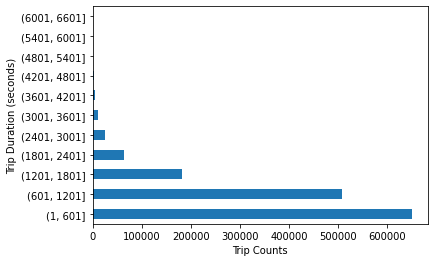

In [37]:
df.trip_duration.groupby(pd.cut(df.trip_duration, np.arange(1,7200,600))).count().plot(kind='barh')
plt.xlabel('Trip Counts')
plt.ylabel('Trip Duration (seconds)')
plt.show()


**hourly Analysis**

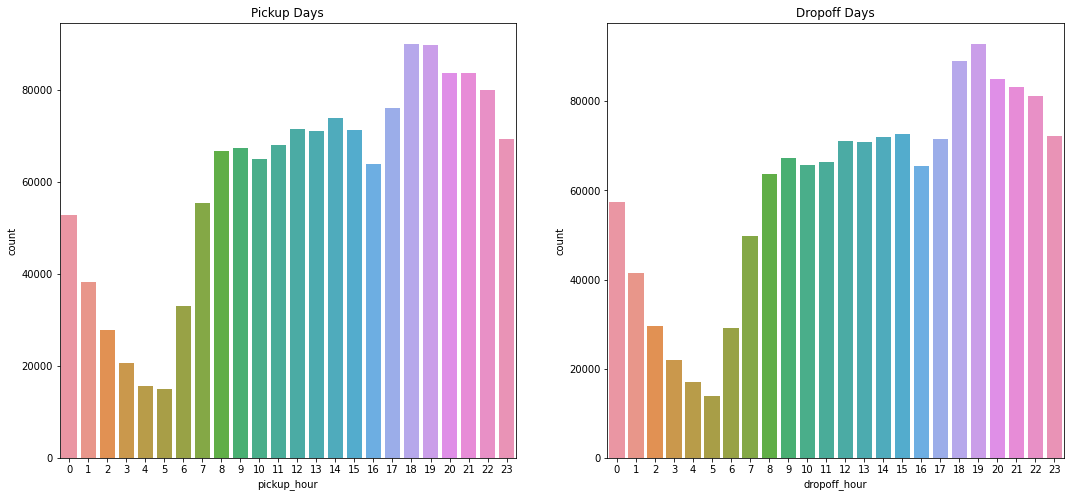

In [38]:
fig, axs = plt.subplots(1,2, figsize=(18, 8))
axs[0].set_title('Pickup Days')


sns.countplot(x=df['pickup_hour'],ax=axs[0])

axs[1].set_title('Dropoff Days')
sns.countplot(x=df['dropoff_hour'],ax=axs[1])

**Monthly Analysis**

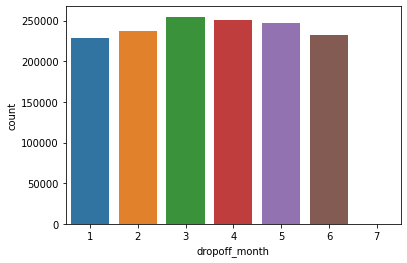

In [39]:
sns.countplot(df['dropoff_month'])


**Setting a time cycle of a day **

**Based on vendor id**

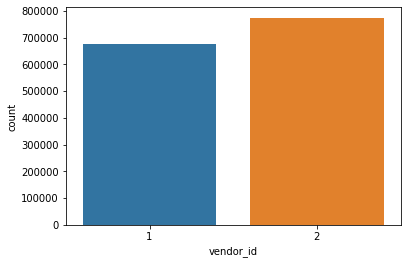

In [40]:
sns.countplot(x='vendor_id',data=df)


**Let's visualize the relationship between Distance covered and respective trip duration.**

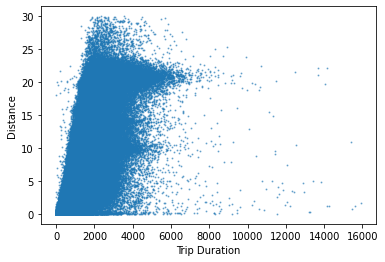

In [48]:
plt.scatter(df.trip_duration, df.distance , s=1, alpha=0.5)
plt.ylabel('Distance')
plt.xlabel('Trip Duration')
plt.show()

** Correlation heatmap**

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True, linewidths=.5)

  #
# displaying heatmap
plt.show()

**Done with data treatment and analysis ,will proceed to split the data in train and testthen will apply supervised ML model**

#splitting data into train and test

In [41]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'distance', 'pickup_day_no', 'dropoff_day_no',
       'pickup_hour', 'dropoff_hour', 'pickup_month', 'dropoff_month'],
      dtype='object')

**We will create some dummy variable for categorical variable**

In [44]:
x=df.drop(['trip_duration','id','pickup_datetime','dropoff_datetime'],axis=1)
y=df['trip_duration']
x=pd.get_dummies(x,'store_and_fwd_flag',drop_first=True)

In [45]:
df.store_and_fwd_flag.value_counts(normalize=True)

N    0.994504
Y    0.005496
Name: store_and_fwd_flag, dtype: float64

In [46]:
# Normalising Predictors and creating new dataframe

from sklearn.preprocessing import StandardScaler

cols = x.columns

ss = StandardScaler()

x = ss.fit_transform(x)
x = pd.DataFrame(x, columns=cols)
x.head()
y

0           455
1           663
2          2124
3           429
4           435
           ... 
1458639     778
1458640     655
1458641     764
1458642     373
1458643     198
Name: trip_duration, Length: 1450106, dtype: int64

In [47]:
x=pd.get_dummies(x,columns=['vendor_id', 
       'passenger_count',
       'pickup_day_no', 'dropoff_day_no', 'pickup_hour', 'dropoff_hour',
       'pickup_month', 'dropoff_month'],drop_first=True)

In [49]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2)


# Using Linear regression ML model

In [54]:
reg = LinearRegression().fit(x_train, y_train)


In [ ]:
regressor.coef_

In [55]:
pred=reg.predict(x_train)

In [56]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(pred,y_train)


0.39876906242504545

# Random Forest Regressor

In [58]:
# import random forest 
from sklearn.ensemble import RandomForestRegressor

In [59]:
regr1 = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
regr1.fit(x_train, y_train)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=3, n_estimators=40, n_jobs=-1)

In [60]:
y_pred = regr1.predict(x_train)
mean_absolute_percentage_error(y_pred, y_train)

0.21453242452421864

#XGboost ML model

In [62]:
import xgboost as xgb

In [ ]:
xgb_model = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,

 subsample=0.8,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.8,)
xgb_model.fit(x_train, y_train)

[18:46:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
y_pred_xgb=xgb_model.predict(x_train)
mean_absolute_percentage_error(y_pred_xgb,y_train)